# Instagram 로그인

In [7]:
##### 하던 중이던거
## 인스타그램 로그인 후 session_id, user_id 를 얻는 과정.

# Chrome driver manager사용

from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
import time
import ssl
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
import pickle
# from fake_useragent import UserAgent

# 아마 https 관련 기능, requests 요청할 때 https 사이트의 경우 필요하다고 함.
ssl._create_default_https_context = ssl._create_unverified_context


user_id = "a"
session_id = "b"


## 이후에 def, if __name__ == '__main__' 방식으로 업데이트 예정
def executor():
    chrome_options = webdriver.ChromeOptions()
    # UserAgent 부분
#     userAgent = UserAgent().random
    userAgent = "Mozilla/5.0 (Linux; Android 9; SM-G975F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.83 Mobile Safari/537.36"
    chrome_options.add_argument(f'user-agent={userAgent}')
    chrome_options.add_argument('--incognito')
    return webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=chrome_options)

# def exec_chrom():
#     options = Options()
#     userAgent = UserAgent().random
#     options.add_argument(f'user-agent={userAgent}')
#     options.add_argument('--incognito')
#     driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
#     driver.maximize_window()
#     driver.get(url)
#     return driver

def user_data(driver):
    global user_id, session_id
    
    # 02. 로그인
    #경로 지정 #동작 제어
    
    login_button = driver.find_element(by=By.XPATH,value = '//*[@class="_ab21"]/div[2]/div[3]/button[1]')
    login_button.click()
    print("click1")
    
    id_inp = driver.find_element(by=By.XPATH,value = '//*[@id="loginForm"]/div[1]/div[3]/div/label')
    id_inp.click()
    id_inp.send_keys("byeongu_son")
    print("click2")
    

    pw_inp = driver.find_element(by=By.XPATH,value = '//*[@id="loginForm"]/div[1]/div[4]/div/label')
    pw_inp.click()
    pw_inp.send_keys("asdf7530**")
    print("click3")
    

    log_btn = driver.find_element(by=By.XPATH,value = '//*[@id="loginForm"]/div[1]/div[6]/button')
    log_btn.click()
    
    time.sleep(4)
    pickle.dump(driver.get_cookies(), open("instagram_cookies.pkl", "wb")) #최초 로그인 후 쿠키 저장시에만
    cookies = pickle.load(open("instagram_cookies.pkl", "rb"))
    for cookie in cookies:
        driver.add_cookie(cookie)
        print(cookie)
        if(cookie['name'] == 'ds_user_id'):
            user_id = cookie['value']
        if(cookie['name'] == 'sessionid'):
            session_id = cookie['value']
            
    return user_id,session_id

    
def login():
    driver = executor()
    driver.set_window_size(414, 800) 	#브라우저 크기 414*800으로 고정
    driver.get('https://www.instagram.com') #인스타그램 웹 켜기
    driver.implicitly_wait(8) 	# 2초 대기
    
    user_id, session_id = user_data(driver)
    print(user_id)
    print(session_id)

# 
# act = ActionChains(dr)      #동작 명령어 지정
# act.send_keys_to_element(id_box, 'rooneei').send_keys_to_element(password_box, 'asdf7530*').click(login_button).perform()     #아이디 입력, 비밀 번호 입력, 로그인 버튼 클릭 수행
# time.sleep(2)



In [1]:
pip install bs4

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: bs4 in c:\ju\lib\site-packages (0.0.1)




[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### 크롤링

In [22]:
# 태그를 입력했을 때, 나오는 게시물들에 관한 json
# header 에서 2개 : Cookie(user_id, Session_id) 와 X-Ig-App-Id' 는 필수로 들어가야 함.)


import requests
from pprint import pprint
from bs4 import BeautifulSoup

url_list =[]

headers = {
    'Accept-Language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
    'Cookie' : f'ds_user_id={user_id}; sessionid={session_id};"',
    'X-Ig-App-Id': '936619743392459',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'
}

def ready(tag_name,user_id,session_id):
    
#     tag_name = "후원"

    base_url = f"https://www.instagram.com/api/v1/tags/web_info/?tag_name={tag_name}"
    headers = {
        'Accept-Language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
        'Cookie' : f'ds_user_id={user_id}; sessionid={session_id};"',
        'X-Ig-App-Id': '936619743392459',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'
    }
    
    response= requests.get(base_url,headers=headers)

    res = response.json()

    # 브라우저에 보이는 9개는 따로 json 파일의 최상단 중, data의 ['top']부분에 저장되어 있음.
    # ['sections'] 부분에 각각 3개씩 한묶음으로 해서 3개의 열이 json 파일로 보관되어 있음.

    all_count = res['count']
    root = res['data']['top']['sections']#[0],[1],[2] # section 다음에 리스트 0~2(브라우저에 보이는 3열)
    # tree1 = root['layout_content']['medias'] # medias 다음에 리스트 0~2(1열, 2열, 3열)
    
    # 브라우저에 보이지 않는 부분들
    invisible_root=res['data']['recent']['sections']# [0] # 여기까지 리스트 ({전체-9개}를 3으로 나눈 값만큼만 유효한 값)
    # other_tree1=other_root['layout_content']['medias'] # 여기까지 리스트 (3개)
    
    return res,root,invisible_root

def check_redirect_contains(url, target_string):
    response = requests.get(url, allow_redirects=False)
    redirected_url = response.headers.get('Location')
    if redirected_url and target_string in redirected_url:
        return redirected_url
    return False


def list(res,root,invisible_root):
    all_count = res['count']
    print(f"전체 게시물 : {all_count}")
    i=1
    for view_list in root:
        for tree in view_list['layout_content']['medias']:
            print (f"------------{i}번째 게시물--------------")
            i+=1
            tag_code = tree['media']['code']
            tag_user = tree['media']['caption']['user']['username']
            print(f"크롤링 게시물 url : https://www.instgram.com/p/{tag_code}")
            
            # 게시물 올린 사람의 인스타 계정으로 이동
            user_url = f'https://www.instagram.com/api/v1/users/web_profile_info/?username={tag_user}'
            print(f"게시자 url : {user_url}")
            
            res = requests.get(user_url, headers=headers)
            # if r1.status_code == 200:
            soup = BeautifulSoup(res.text, 'html.parser')
            href_values = ""

            # Find the div tag with class 'x3nfvp2'
            div_tags = soup.find_all('div', class_='x3nfvp2')
            print(f"div tags : {div_tags}")
            for div in div_tags:
                print(f"div attrs 개수: {len(div.attrs)}")
                if len(div.attrs) == 1:
                    print(f"div : {div}")
                    a_tags = single_attribute_divs.find('a')
                    print(a_tags)
                    href_values = a['href']
                    print(href_values)
                else:
                    continue
#             try:
#                     user_response= requests.get(user_url,headers=headers)
#                 except:
#                     main()
#                     user_response= requests.get(user_url,headers=headers)

            
            # 그 인스타 계정의 다른 외부 주소가 Naver Smart Store 인 경우에만 접속.
            external_url = href_values
            target_string = "smartstore.naver.com"
            
            if external_url and ( ( target_string in external_url ) or ( check_redirect_contains(external_url,target_string) ) ):
                if check_redirect_contains(external_url,target_string):
                    external_url = check_redirect_contains(external_url,target_string)
                if not (external_url in url_list):
                    print(f"Smart Store url : {external_url}")
                    url_list.append(external_url)
            else:
                print("XXXXXXXXXXXXXXXXXXXX", end = "\n\n\n")
                
    print("-----------=====-보이지 않는 게시물------=====------------")
    return

    limit = all_count-9
    custom_limit = 20
    break_check = False
    count = 0
    for invisible_list in invisible_root:
        if(break_check):
            break
        for tree in invisible_list['layout_content']['medias']: # 여기까지 리스트 (3개)
            if ((i > limit) or (i> custom_limit)):
                break_check = True
                break
            else:
                print (f"------------{i}번째 게시물--------------")
                i+=1
                tag_code = tree['media']['code']
                tag_user = tree['media']['caption']['user']['username']
                print(f"크롤링 게시물 url : https://www.instgram.com/p/{tag_code}")

                # 게시물 올린 사람의 인스타 계정으로 이동
                user_url = f'https://www.instagram.com/api/v1/users/web_profile_info/?username={tag_user}'
                print(f"게시자 url : {user_url}")
                try:
                    user_response= requests.get(user_url,headers=headers)
                except:
                    main()
                    user_response= requests.get(user_url,headers=headers)

                # 그 인스타 계정의 다른 외부 주소가 Naver Smart Store 인 경우에만 접속.
                external_url = user_response.json()['data']['user']['external_url']
                target_string = "smartstore.naver.com"

                if external_url and ( ( target_string in external_url ) or ( check_redirect_contains(external_url,target_string) ) ):
                    if check_redirect_contains(external_url,target_string):
                        external_url = check_redirect_contains(external_url,target_string)
                    if not (external_url in url_list):
                        print(f"Smart Store url : {external_url}")
                        url_list.append(external_url)
                else:
                    print("XXXXXXXXXXXXXXXXXXXX", end = "\n\n\n")
            


In [23]:
if __name__ == '__main__':
#     user_id = "a"
#     session_id = "b"
#     login()
#     response,root,invisible_root = ready("후원브랜드",user_id,session_id) # 각 게시물 별 root 추가

    list(response,root,invisible_root) # 게시물 순 리스트 출력, url_list 에 각 스마트스토어 리스트 추가

전체 게시물 : 1533
------------1번째 게시물--------------
크롤링 게시물 url : https://www.instgram.com/p/Cuazki5BRhQ
게시자 url : https://www.instagram.com/api/v1/users/web_profile_info/?username=ddasunhae
div tags : []
XXXXXXXXXXXXXXXXXXXX


------------2번째 게시물--------------
크롤링 게시물 url : https://www.instgram.com/p/CuZ1eYQJS3D
게시자 url : https://www.instagram.com/api/v1/users/web_profile_info/?username=ffm13_official
div tags : []
XXXXXXXXXXXXXXXXXXXX


------------3번째 게시물--------------
크롤링 게시물 url : https://www.instgram.com/p/Cu37XHAutyX
게시자 url : https://www.instagram.com/api/v1/users/web_profile_info/?username=dr.munji
div tags : []
XXXXXXXXXXXXXXXXXXXX


------------4번째 게시물--------------
크롤링 게시물 url : https://www.instgram.com/p/CugE6vwLRTO
게시자 url : https://www.instagram.com/api/v1/users/web_profile_info/?username=puffy._.thing
div tags : []
XXXXXXXXXXXXXXXXXXXX


------------5번째 게시물--------------
크롤링 게시물 url : https://www.instgram.com/p/Cjc3p61riZk
게시자 url : https://www.instagram.com/api/v1/users/we

<!DOCTYPE html><html class="_9dls" lang="ko" dir="ltr"><head><link data-default-icon="https://static.cdninstagram.com/rsrc.php/v3/yt/r/30PrGfR3xhB.png" rel="icon" sizes="192x192" href="https://static.cdninstagram.com/rsrc.php/v3/yt/r/30PrGfR3xhB.png" /><meta charset="utf-8" /><meta name="apple-mobile-web-app-status-bar-style" content="default" /><meta name="mobile-web-app-capable" content="yes" /><meta id="viewport" name="viewport" content="width=device-width, initial-scale=1, minimum-scale=1, maximum-scale=2, viewport-fit=cover" /><meta name="theme-color" content="#ffffff" /><meta name="theme-color" content="#000000" media="(prefers-color-scheme: dark)" /><link rel="apple-touch-icon" sizes="76x76" href="https://static.cdninstagram.com/rsrc.php/v3/yR/r/lam-fZmwmvn.png" /><link rel="apple-touch-icon" sizes="120x120" href="https://static.cdninstagram.com/rsrc.php/v3/ys/r/aM-g435MtEX.png" /><link rel="apple-touch-icon" sizes="152x152" href="https://static.cdninstagram.com/rsrc.php/v3/yx/r
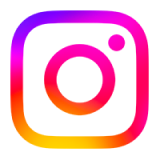
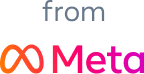

In [29]:
a_url = "https://www.instagram.com/de_lemon_market/"
headers = {
    'Accept-Language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
    'Cookie' : f'ds_user_id={user_id}; sessionid={session_id};"',
    'X-Ig-App-Id': '936619743392459',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'
}
res = requests.get(a_url, headers=headers)
# if r1.status_code == 200:
soup = BeautifulSoup(res.text, 'html.parser')
print(res.text)
href_values = ""

# Find the div tag with class 'x3nfvp2'
div_tags = soup.find_all('div', class_='x3nfvp2')
print(f"div tags : {div_tags}")

In [27]:
login()

click1
click2
click3
{'domain': '.instagram.com', 'httpOnly': True, 'name': 'rur', 'path': '/', 'sameSite': 'Lax', 'secure': True, 'value': '"EAG\\0549678042146\\0541721372695:01f75f6db502bd144f34e99dfdcd5d6057f0625c4ae67819dd5af9ca0a0747caf89a654e"'}
{'domain': '.instagram.com', 'expiry': 1690441496, 'httpOnly': True, 'name': 'shbid', 'path': '/', 'sameSite': 'Lax', 'secure': True, 'value': '"2588\\0549678042146\\0541721372695:01f7e90392ddbde5e809cdf787fa4dc8b53c2594eb6cce89e69273849b14069a9a6e4a2e"'}
{'domain': '.instagram.com', 'expiry': 1690441496, 'httpOnly': True, 'name': 'shbts', 'path': '/', 'sameSite': 'Lax', 'secure': True, 'value': '"1689836695\\0549678042146\\0541721372695:01f74966c393eb513823e3b526357b47ea585fd10d6830e2ece077a4867a1d71e01c8b04"'}
{'domain': '.instagram.com', 'expiry': 1721372696, 'httpOnly': True, 'name': 'sessionid', 'path': '/', 'sameSite': 'Lax', 'secure': True, 'value': '9678042146%3AKrxItf54CqlOAl%3A25%3AAYc6J7m1BhZV147mvXRSX_aBslGo6ZDpBpCOA8XI4A'}
{'